In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from cemba_data.tools.integration.utilities import calculate_direct_confusion
from ALLCools.plot import *
from ALLCools.plot.color import plot_colorbar

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

In [3]:
cell_select_level = 'CellClass'
cell_select = ['Inh']

cluster_col = 'SubType'
region_col = 'SubRegion'
region_order = [
    'PFC', 'ACA', 'ORB', 'AI', 'MOs', 'MOp', 'SSp', 'SSs',
    'CA1-3', 'DG', 'MOB', 'AON', 'PIR', 'CP', 'ACB', 'PAL', 'LSX'
]

region_order = [
    'PFC', 'ACA', 'ORB', 'AI', 'MOs', 'MOp', 'SSp', 'SSs'
]

## Tidy Data

In [4]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'

## Exc

In [6]:
_cell_tidy_data = cell_tidy_data.loc[cell_tidy_data[cell_select_level].isin(cell_select), :]

region_overlap = calculate_direct_confusion(_cell_tidy_data[[region_col, cluster_col]], 
                                                _cell_tidy_data[[region_col, cluster_col]])
region_overlap = region_overlap.loc[region_order, region_order].copy()

In [7]:
bar_data = cell_tidy_data[cell_tidy_data['CellClass'] != 'NonN'].groupby(region_col)['CellClass'].value_counts().unstack()
bar_data = (bar_data / bar_data.sum(axis=1).values[:, None]).reset_index()

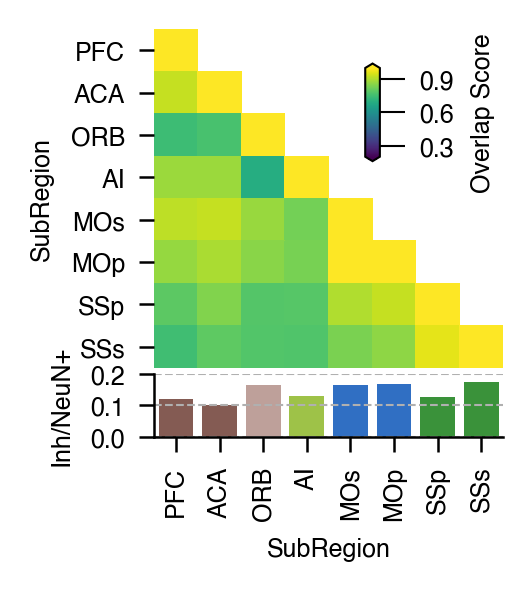

In [20]:
mask = np.zeros_like(region_overlap)
mask[np.triu_indices_from(mask, 1)] = True

fig = plt.figure(figsize=(1.5, 1.8), dpi=300)

gs = fig.add_gridspec(12, 20)
ax_bar = fig.add_subplot(gs[10:12, :20])
ax_heatmap = fig.add_subplot(gs[:10, :20])
cax = fig.add_subplot(gs[1:4, -8])

ax = ax_heatmap
sns.heatmap(ax=ax, data=region_overlap, vmin=0.2, vmax=0.9,
            mask=mask, cmap='viridis', cbar=None)
ax.set(ylim=(len(region_order), 0), xticks=[],
       xlabel='')

from matplotlib.cm import get_cmap
cmap = get_cmap('viridis')
plot_colorbar(
    cax,
    cmap,
    hue_norm=(0.2, 1),
    cnorm=None,
    label='Overlap Score',
    orientation='vertical',
    labelsize=labelsize,
    linewidth=0.5)

ax = ax_bar
sns.barplot(ax=ax, data=bar_data, palette=sub_region_palette,
            x=region_col, y='Inh', order=region_order)
ax.set_ylabel(f'Inh/NeuN+')
ax.xaxis.set_tick_params(rotation=90)
ax.set_yticks([0, 0.1, 0.2])
ax.grid(axis='y', linewidth=0.5, linestyle='--')
sns.despine(ax=ax)

fig.savefig('Cortex.Inh.overlap_matrix.pdf', bbox_inches='tight')

In [19]:
def get_replicate_overlap():
    _cell_tidy_data = cell_tidy_data.loc[cell_tidy_data['CellClass'] == cell_class, :]

    replicate_overlap = calculate_direct_confusion(_cell_tidy_data[['Replicate', cluster_col]], 
                                                   _cell_tidy_data[['Replicate', cluster_col]])
    records = {}
    for (a, b), value in replicate_overlap.unstack().iteritems():
        region_a = a.split('-')[0]
        region_b = b.split('-')[0]
        if (region_a == region_b) and (a != b):
            records[(a, b)] = value
    replicate_overlap = pd.Series(records)
    return replicate_overlap